In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
from scipy.sparse import csc_matrix
from scipy.sparse.linalg import spsolve
from scipy.sparse.linalg import lsqr
from matplotlib import cm

# Define functions: Kernel, interpolation

Kernel function

In [2]:
def phi(const, point, centre):
    result = np.exp(- const * np.sum((point-centre) ** 2,axis=1))
    return result

Interpolation function

In [3]:
def intpl_func(points, centre, weight, const):
    return(np.sum(weight.ravel() * phi(const, points, centre)))


# Determine parameters

In [12]:
start_fr = 200 # start frame
end_fr = start_fr + 1 # end frame
const = 1 # constant in kernel
scaling = 0.01 # scaling of position vectors in data
weight = 1.5 # weight of IQR method
number_c = 50 # number_c ** 2 = the number of points of centre's of rbf function
number_k = 0 # the number of points in k-neighbourhood (if set to 0, we will use cutoff distance below)
cutoff_dist = 0 # distance criterion for the neighbour
grid_number_x = 50 # dense of x-axis grid for plotting interpolated functions
grid_number_y = 50

# Data processing

Read data, and screen data for the particular frames

In [13]:
data = pd.read_csv('MOT16-04.csv')
df = data.loc[:,['frame_id','pedestrianId','Xt','Yt']]

start_df = df.loc[(df['frame_id'] == start_fr)]
end_df = df.loc[(df['frame_id'] == end_fr)]

Find same ped_id in start/end frames and calculate position/speed vectors and norm

In [14]:
df = pd.merge(start_df, end_df, on = 'pedestrianId', suffixes = ('_s', '_e'))
df[['Xt_s','Yt_s','Xt_e','Yt_e']] *= scaling

df['U'] = df['Xt_e'] - df['Xt_s']
df['V'] = df['Yt_e'] - df['Yt_s']
df['Norm'] = np.sqrt(df['U'] ** 2 + df['V'] ** 2)


Remove outliers from norm, by the IQR method

In [15]:
def IQR(data, weight):
    quantile_25 = np.percentile(data, 25)
    quantile_75 = np.percentile(data, 75)

    IQR = quantile_75 - quantile_25
    IQR_weight = IQR * weight

    lowest = quantile_25 - IQR_weight
    highest = quantile_75 + IQR_weight
    return((data >= lowest) & (data <= highest))

# Calculate interpolation function

Calculate weight of interpolation functions(k-neighbourhood)

In [16]:
ini_vector = df[IQR(df['Norm'],weight)]
ini_xy = ini_vector.loc[:,['Xt_s','Yt_s']].values
print("Number of valid pedestrians: ",len(ini_vector))

min_x = min(ini_xy[:,0])
max_x = max(ini_xy[:,0])
min_y = min(ini_xy[:,1])
max_y = max(ini_xy[:,1])

rbf_x, rbf_y = np.meshgrid(np.linspace(min_x, max_x, number_c), np.linspace(min_y, max_y, number_c))
rbf_c = np.vstack([rbf_x.ravel(), rbf_y.ravel()]).T

phi_array = np.zeros((len(ini_xy), len(rbf_c))) ## TODO: use dictionary when the matrix gets large
n_neighbour = 0
for i in range(len(ini_xy)):
    col_dist = np.sqrt(np.sum((rbf_c-ini_xy[i])**2,axis=1))
    if number_k>0:
        dist_sort_index = col_dist.argsort()
        nei_index = dist_sort_index[:number_k]
    else:
        nei_index = np.where(col_dist<cutoff_dist)[0]
        n_neighbour += len(nei_index)
    phi_array[i,nei_index] = phi(const, ini_xy[i], rbf_c[nei_index])
print("average number of neighbours: ",n_neighbour/len(ini_xy))

weight_x = lsqr(csc_matrix(phi_array), ini_vector['U'])[0]
weight_y = lsqr(csc_matrix(phi_array), ini_vector['V'])[0]

Number of valid pedestrians:  26
average number of neighbours:  0.0
The exact solution is  x = 0                              
The exact solution is  x = 0                              


Calculate interpolation functions

In [17]:
grid_x0 = np.linspace(min_x - (100 * scaling), max_x + (100 * scaling), grid_number_x)
grid_y0 = np.linspace(min_y - (100 * scaling), max_y + (100 * scaling), grid_number_y)

grid_x, grid_y = np.meshgrid(grid_x0, grid_y0)
grid_xy = np.vstack([grid_x.ravel(), grid_y.ravel()]).T

intpl_u = []
intpl_v = []
for xy in grid_xy:
    intpl_u.append(intpl_func(xy, rbf_c, weight_x, const))
    intpl_v.append(intpl_func(xy, rbf_c, weight_y, const))

Draw figures

/Users/kaji/opt/anaconda3/lib/python3.8/site-packages/matplotlib/quiver.py:686: RuntimeWarning: divide by zero encountered in double_scalars
  length = a * (widthu_per_lenu / (self.scale * self.width))
/Users/kaji/opt/anaconda3/lib/python3.8/site-packages/matplotlib/quiver.py:686: RuntimeWarning: invalid value encountered in multiply
  length = a * (widthu_per_lenu / (self.scale * self.width))


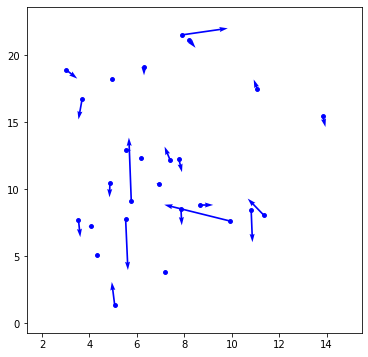

In [18]:
plt.figure(figsize=(6, 6))
plt.quiver(grid_xy[:,0], grid_xy[:,1], intpl_u, intpl_v)
plt.scatter(ini_xy[:,0], ini_xy[:,1], s=15, c='b')
plt.quiver(ini_xy[:,0], ini_xy[:,1], ini_vector['U'], ini_vector['V'], width=0.005, color='blue')
plt.savefig("org.png")
plt.show()